In [3]:
import os
import shutil

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
base_dir = '/content/drive/MyDrive/Plant Disease Detection'
rice_dir = os.path.join(base_dir, 'Rice Leaf Disease Images')
wheat_dir = os.path.join(base_dir, 'Wheat Leaf Disease Images')
combined_dir = '/content/combined_disease_dataset'

In [45]:
def copy_disease_folders(src_dir, prefix):
    for disease in os.listdir(src_dir):
        disease_path = os.path.join(src_dir, disease)
        if os.path.isdir(disease_path):
            new_disease_name = f"{prefix}_{disease}"
            dest_path = os.path.join(combined_dir, new_disease_name)

            # Remove existing folder first
            if os.path.exists(dest_path):
                shutil.rmtree(dest_path)
                print(f"Deleted existing {dest_path}.")

            shutil.copytree(disease_path, dest_path)
            print(f"Copied {dest_path}.")
# Copy rice and wheat folders with prefixes
copy_disease_folders(rice_dir, "Rice")
copy_disease_folders(wheat_dir, "Wheat")

Deleted existing /content/combined_disease_dataset/Rice_Tungro.
Copied /content/combined_disease_dataset/Rice_Tungro.
Deleted existing /content/combined_disease_dataset/Rice_Blast.
Copied /content/combined_disease_dataset/Rice_Blast.
Deleted existing /content/combined_disease_dataset/Rice_Brownspot.
Copied /content/combined_disease_dataset/Rice_Brownspot.
Deleted existing /content/combined_disease_dataset/Rice_Bacterialblight.
Copied /content/combined_disease_dataset/Rice_Bacterialblight.
Deleted existing /content/combined_disease_dataset/Wheat_Healthy.
Copied /content/combined_disease_dataset/Wheat_Healthy.
Deleted existing /content/combined_disease_dataset/Wheat_Loose Smut.
Copied /content/combined_disease_dataset/Wheat_Loose Smut.
Deleted existing /content/combined_disease_dataset/Wheat_Septoria.
Copied /content/combined_disease_dataset/Wheat_Septoria.
Deleted existing /content/combined_disease_dataset/Wheat_Brown rust.
Copied /content/combined_disease_dataset/Wheat_Brown rust.
Dele

In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [47]:
img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_data = datagen.flow_from_directory(
    combined_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    combined_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 9173 images belonging to 9 classes.
Found 2290 images belonging to 9 classes.


In [48]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

In [49]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = True


# Freeze base model layers
for layer in base_model.layers[:-40]:
    layer.trainable = False


# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.3)(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [50]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [52]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [53]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 232s 741ms/step - accuracy: 0.4988 - loss: 1.7511 - val_accuracy: 0.4415 - val_loss: 3.3935
Epoch 2/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 194s 677ms/step - accuracy: 0.8955 - loss: 0.5576 - val_accuracy: 0.5122 - val_loss: 3.1728
Epoch 3/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 194s 678ms/step - accuracy: 0.9406 - loss: 0.4061 - val_accuracy: 0.6380 - val_loss: 2.0099
Epoch 4/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 203s 680ms/step - accuracy: 0.9561 - loss: 0.3496 - val_accuracy: 0.6734 - val_loss: 1.9742
Epoch 5/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 196s 683ms/step - accuracy: 0.9689 - loss: 0.3090 - val_accuracy: 0.7472 - val_loss: 1.5796
Epoch 6/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 201s 701ms/step - accuracy: 0.9716 - loss: 0.3014 - val_accuracy: 0.8061 - val_loss: 1.3024
Epoch 7/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 198s 692ms/step - accuracy: 0.9774 - loss: 0.2714 - val_accuracy: 0.7939 - val_loss: 1.8090
Epoch 8/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 194s 676ms/step - accuracy: 0.9792 -

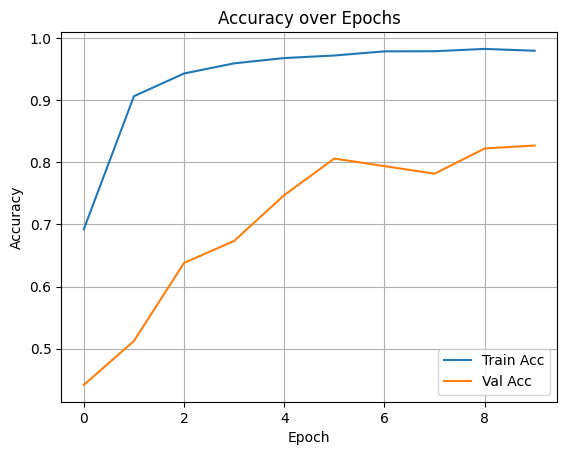

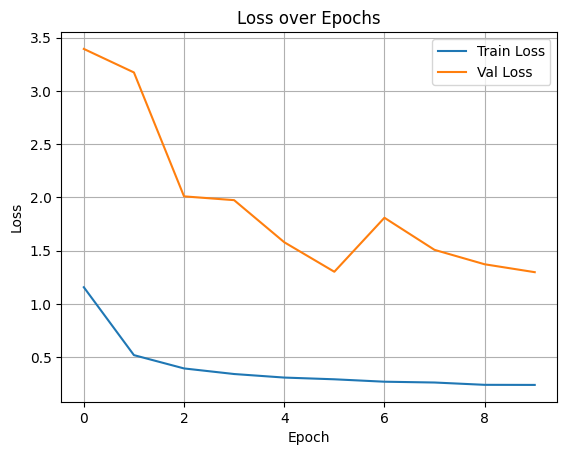

In [54]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [59]:
model.save('/content/drive/MyDrive/Plant Disease Detection/plant_disease_model_final.h5')

In [56]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

In [61]:
model = load_model('/content/drive/MyDrive/Plant Disease Detection/plant_disease_model_final.h5')

In [62]:
class_indices = train_data.class_indices
class_labels = list(class_indices.keys())

In [63]:
def predict_disease_with_crop(img_path, crop_type):
    crop_type = crop_type.capitalize()  # Ensure format matches ("Rice", "Wheat")

    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction)
    predicted_class = class_labels[predicted_index]
    confidence = np.max(prediction) * 100

    # Check if the predicted class belongs to the given crop type
    if predicted_class.startswith(crop_type):
        disease_name = predicted_class.split('_', 1)[1]  # Remove prefix (e.g., "Rice_Blast" → "Blast")
        result = f"{crop_type} disease detected: {disease_name} ({confidence:.2f}%)"
    else:
        result = f"Warning: Image may not belong to {crop_type} crop. Predicted: {predicted_class} ({confidence:.2f}%)"

    # Display result
    plt.imshow(img)
    plt.axis('off')
    plt.title(result)
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


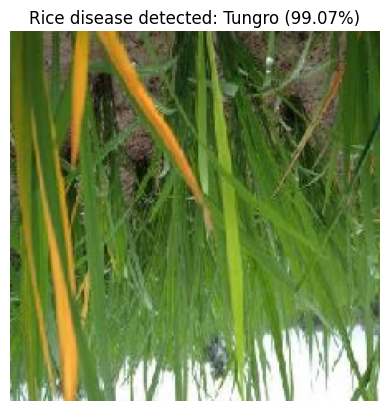

In [64]:
predict_disease_with_crop('/content/drive/MyDrive/Plant Disease Detection/Rice Leaf Disease Images/Tungro/TUNGRO5_106.jpg','rice')